In [1]:
'''
This script shows how to predict stock prices using a basic RNN
'''
import tensorflow as tf
import numpy as np
import matplotlib
import os

tf.set_random_seed(777)  # reproducibility

if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
//anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [3]:
# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 3000

In [4]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

In [6]:
x

array([[2.13751054e-01, 2.08179810e-01, 1.91791832e-01, 4.66075110e-04,
        1.92092403e-01],
       [1.93935034e-01, 2.03641926e-01, 2.08664571e-01, 2.98467330e-03,
        1.96551555e-01],
       [2.10516454e-01, 2.05289413e-01, 2.03558748e-01, 2.59926504e-04,
        1.87749731e-01],
       ...,
       [9.47895670e-01, 9.49273354e-01, 9.72504893e-01, 1.14170476e-01,
        9.66454635e-01],
       [9.56900354e-01, 9.59881106e-01, 9.80354497e-01, 1.42502465e-01,
        9.77850239e-01],
       [9.73335806e-01, 9.75431522e-01, 1.00000000e+00, 1.11123062e-01,
        9.88313020e-01]])

In [9]:
x.shape

(732, 5)

In [5]:
xy.shape

(732, 5)

In [10]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] -> [0.13289962]
[[1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.3641

In [6]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

In [7]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [8]:
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

In [9]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [10]:
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

[step: 0] loss: 69.09278106689453
[step: 1] loss: 30.794803619384766
[step: 2] loss: 9.389269828796387
[step: 3] loss: 5.233710765838623
[step: 4] loss: 13.087111473083496
[step: 5] loss: 18.271379470825195
[step: 6] loss: 15.748316764831543
[step: 7] loss: 9.893643379211426
[step: 8] loss: 4.928186416625977
[step: 9] loss: 2.5893139839172363
[step: 10] loss: 2.6588518619537354
[step: 11] loss: 4.01442289352417
[step: 12] loss: 5.4730658531188965
[step: 13] loss: 6.244162559509277
[step: 14] loss: 6.045577526092529
[step: 15] loss: 5.017136573791504
[step: 16] loss: 3.558063507080078
[step: 17] loss: 2.1578891277313232
[step: 18] loss: 1.2399548292160034
[step: 19] loss: 1.0243396759033203
[step: 20] loss: 1.4398081302642822
[step: 21] loss: 2.1448724269866943
[step: 22] loss: 2.6970765590667725
[step: 23] loss: 2.796844959259033
[step: 24] loss: 2.433290958404541
[step: 25] loss: 1.834783911705017
[step: 26] loss: 1.2961550951004028
[step: 27] loss: 1.0181523561477661
[step: 28] loss:

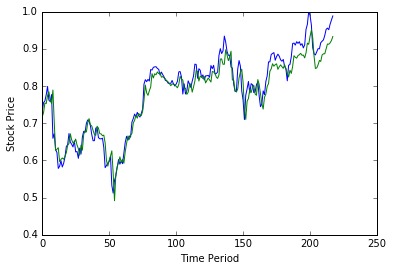

In [11]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()